# Librerias y datos

In [1]:
# Librerias necesarias
import pandas as pd
import numpy as np
from scipy import stats, optimize
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [ ]:
# Cargar los datos
df = pd.read_excel("../2. data/0 TimeLog (original, no modificar).xlsx")

In [3]:
# Copio para no modificar el original
tl = df.copy()

In [ ]:
# Agrego LOS a cada fila
tl["LOS"] = (tl["TF"] - tl["TI"])

# Ajuste a Log_Normal

In [5]:
# descomentar las partes de plot si es que se quiere graficar
def ajuste_lognormal(tl):
    resultados = []
    for i in range(1,4):
        for unidad in ["ICU", "SDU_WARD"]:
            fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
            axs = axs.flatten()  # para indexar fácilmente como lista
            plot_idx = 0  # índice del subplot
            for grd in range(1,9):

                # ---- 1. Filter your dataset
                tl_u = tl[tl["UNIDAD"].isin(["ICU", "OR", "SDU_WARD"])]
                v1 = tl_u[(tl_u["UNIDAD"] == unidad) & (tl_u["MS_GRD"] == grd) & (tl_u["HOSPITAL"] == f"Hospital_{i}")]

                # ---- 2. Get LOS value counts
                vector = v1["LOS"].value_counts().reset_index().sort_values(by="LOS")
                vector.columns = ["LOS", "count"]

                # ---- 3. Build raw data from LOS values and their frequencies
                los = np.array(vector["LOS"])/12
                ocurrencias = np.array(vector["count"])
                raw_data = np.repeat(los, ocurrencias)
                
                # ---- 3.5. Transformar data discreta a uniforme
                

                # ---- 4. Definir los bins de 12 horas
                bin_width = 1 # equivalen a 12 horas
                max_los = np.max(raw_data)
                edges = np.arange(0, max_los + bin_width, bin_width)
                midpoints = (edges[:-1] + edges[1:]) / 2  # midpoint of (a, b] is (a + b) / 2

                # ---- 5. Meter datos a bins individuales (0 - 12], (12 - 24], ...)
                # agrega 0 si no hay datos para ese bin
                bin_indices = np.digitize(raw_data, edges, right=True)
                hist = np.array([(bin_indices == i).sum() for i in range(1, len(edges))])

    #--------------------------------Hasta aca esta bien----------------------------------------

                # ---- 6. Ajustar log normal a datos usando metodo "MLE"
                shape, loc, scale = stats.lognorm.fit(raw_data, floc=0)

                # ---- Optimización
                def chi2_objective(params, hist, edges, total_count):
                    shape, loc, scale = params
                    # Ensure parameters are valid
                    if shape <= 0 or scale <= 0:
                        return np.inf
                    cdf_low = stats.lognorm.cdf(edges[:-1], shape, loc, scale)
                    cdf_high = stats.lognorm.cdf(edges[1:], shape, loc, scale)
                    expected_probs = cdf_high - cdf_low
                    expected_counts = expected_probs * total_count

                    # Mask for bins with enough expected values
                    mask = expected_counts >= 5
                    if not np.any(mask):
                        return np.inf
                    obs = hist[mask]
                    exp = expected_counts[mask]
                    
                    # Normalize expected to match sum of obs
                    exp *= obs.sum() / exp.sum()
                    chi2 = np.sum((obs - exp)**2 / exp)
                    return chi2
                
                initial_shape, initial_loc, initial_scale = stats.lognorm.fit(raw_data, floc=0)
                # Minimize the chi-square
                result = optimize.minimize(
                    chi2_objective,
                    x0=[initial_shape, initial_loc, initial_scale],
                    args=(hist, edges, len(raw_data)),
                    bounds=[(1e-5, None), (0, None), (1e-5, None)],
                    method='L-BFGS-B'
                )
                # Extract optimized parameters
                opt_shape, opt_loc, opt_scale = result.x
                shape = opt_shape
                loc = opt_loc
                scale = opt_scale


                # ---- 7. Compute expected counts per bin using log-normal CDF
                cdf_low = stats.lognorm.cdf(edges[:-1], shape, loc, scale)
                cdf_high = stats.lognorm.cdf(edges[1:], shape, loc, scale)
                expected_probs = cdf_high - cdf_low
                expected_counts = expected_probs * len(raw_data)

                # ---- 9. Chi-square test (only where expected counts ≥ 5)
                mask = expected_counts >= 5
                obs = hist[mask]
                exp = expected_counts[mask]

                # Normalize expected counts to match the total of observed
                if exp.sum() > 0:
                    exp *= obs.sum() / exp.sum()

                # Chi-square test
                if np.any(mask):
                    chi2, p = stats.chisquare(f_obs=obs, f_exp=exp)

                # print(f'Unidad={unidad}, Hospital={i}, GRD={grd}, Chi² = {chi2:.2f}, valor-p = {p:.4f}')
                resultados.append({
                    "Hospital": i,
                    "Unidad": unidad,
                    "GRD": grd,
                    "Chi2": chi2,
                    "p-value": round(p,4)
                })
                # ---- 8. Plot observed vs. expected
                ax = axs[plot_idx]
                plot_idx += 1  # avanzar al siguiente subplot
                ax.bar(midpoints, hist, width=bin_width - 2, alpha=0.6, label='Valores observados')
                ax.set_xlabel('LOS (horas)')
                ax.set_ylabel('Frecuencia')
                ax.set_title(f'{unidad}, Hosp {i}, GRD {grd}, Chi² = {chi2:.2f}, p = {p:.4f}')
                ax.grid(True)

                # Curva log-normal ajustada
                x_vals = np.linspace(1, max_los, 500)
                pdf_vals = stats.lognorm.pdf(x_vals, s=shape, loc=loc, scale=scale)
                pdf_scaled = pdf_vals * len(raw_data) * bin_width
                ax.plot(x_vals, pdf_scaled, 'g-', label='Log-normal')

                # Opcional: línea vertical para el corte de cola
                # ax.axvline(umbral_corte, color='gray', linestyle='--', label='Corte percentil')

                ax.legend()

    resultados_df = pd.DataFrame(resultados)
    plt.tight_layout()
    plt.show()
    return resultados_df

/var/folders/ws/h3j5xbbs1s72dytc70rd22000000gn/T/ipykernel_4620/1454510597.py:63: RuntimeWarning: invalid value encountered in divide
  chi2 = np.sum((obs - exp)**2 / exp)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/ws/h3j5xbbs1s72dytc70rd22000000gn/T/ipykernel_4620/1454510597.py:63: RuntimeWarning: invalid value encountered in divide
  chi2 = np.sum((obs - exp)**2 / exp)


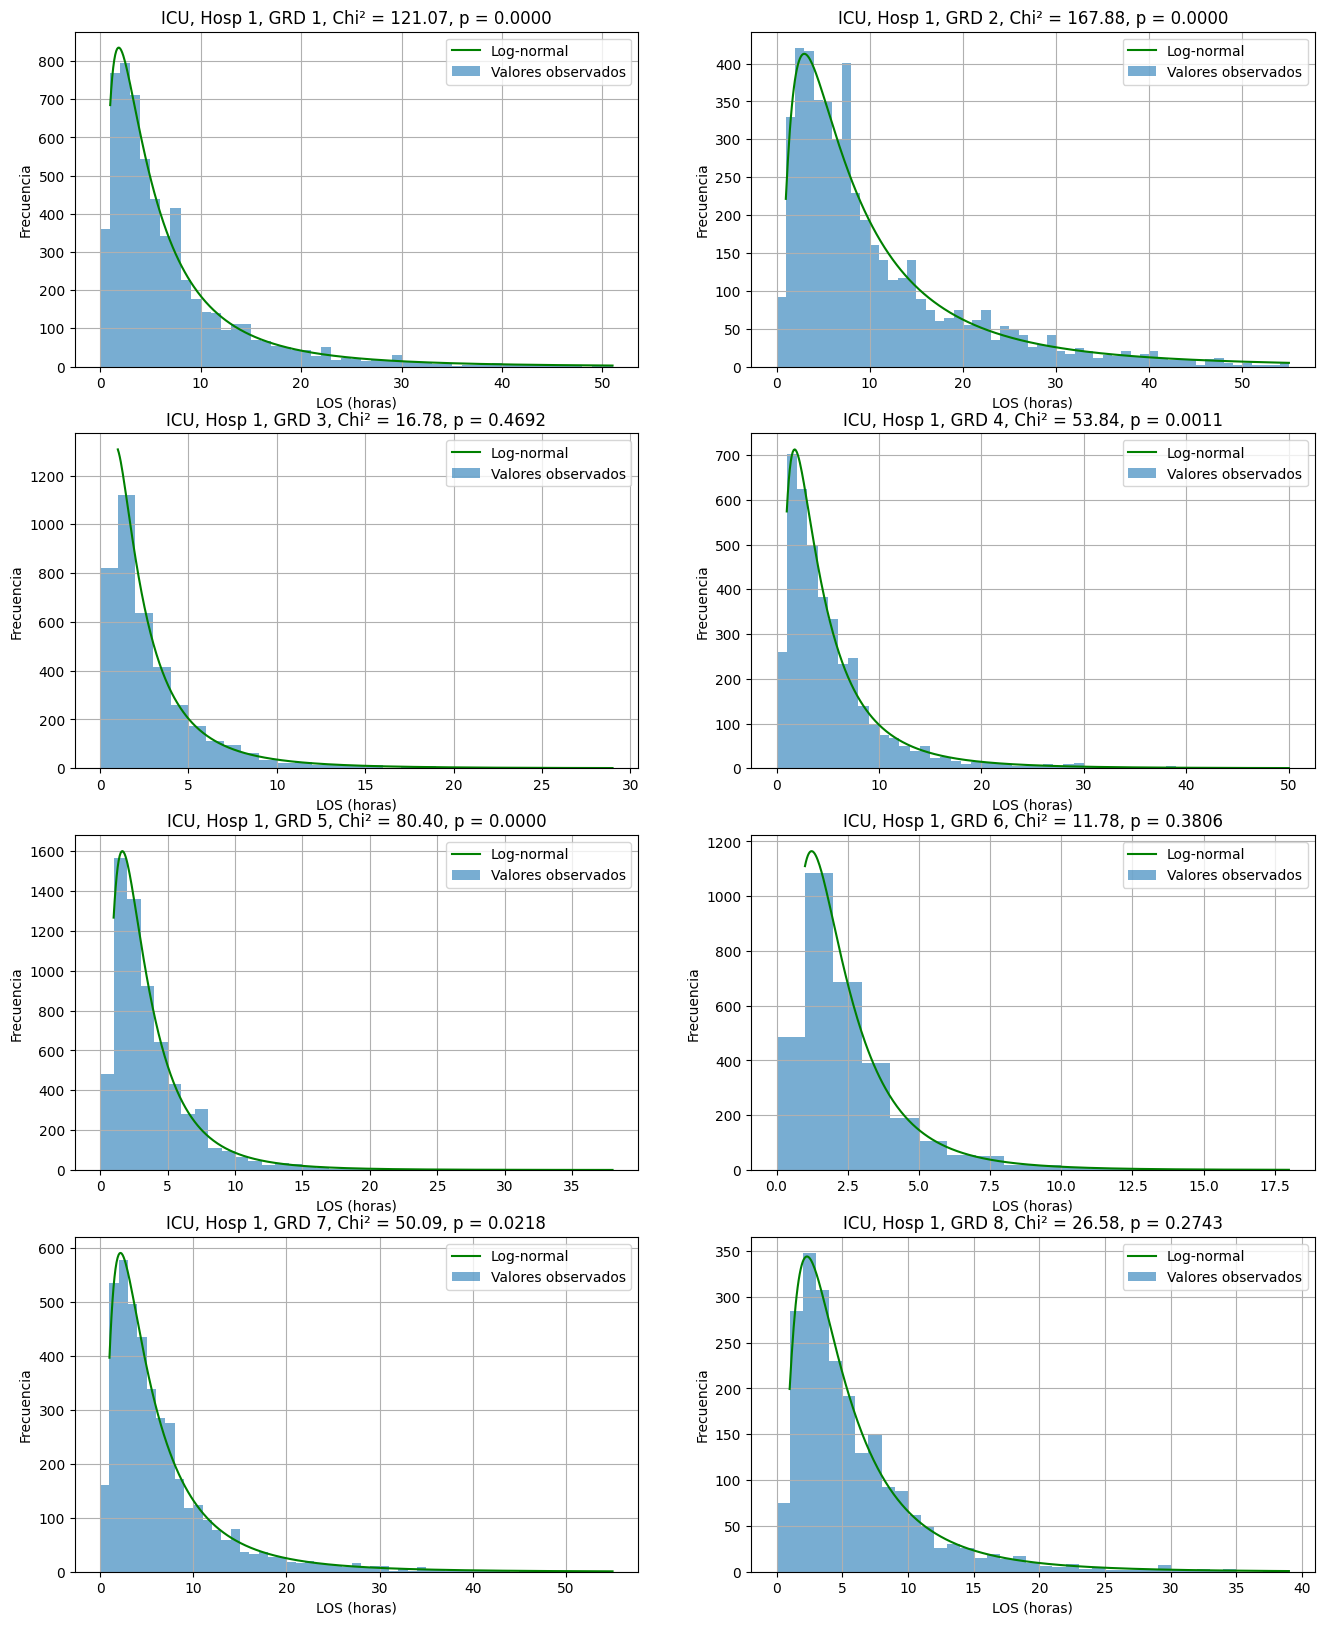

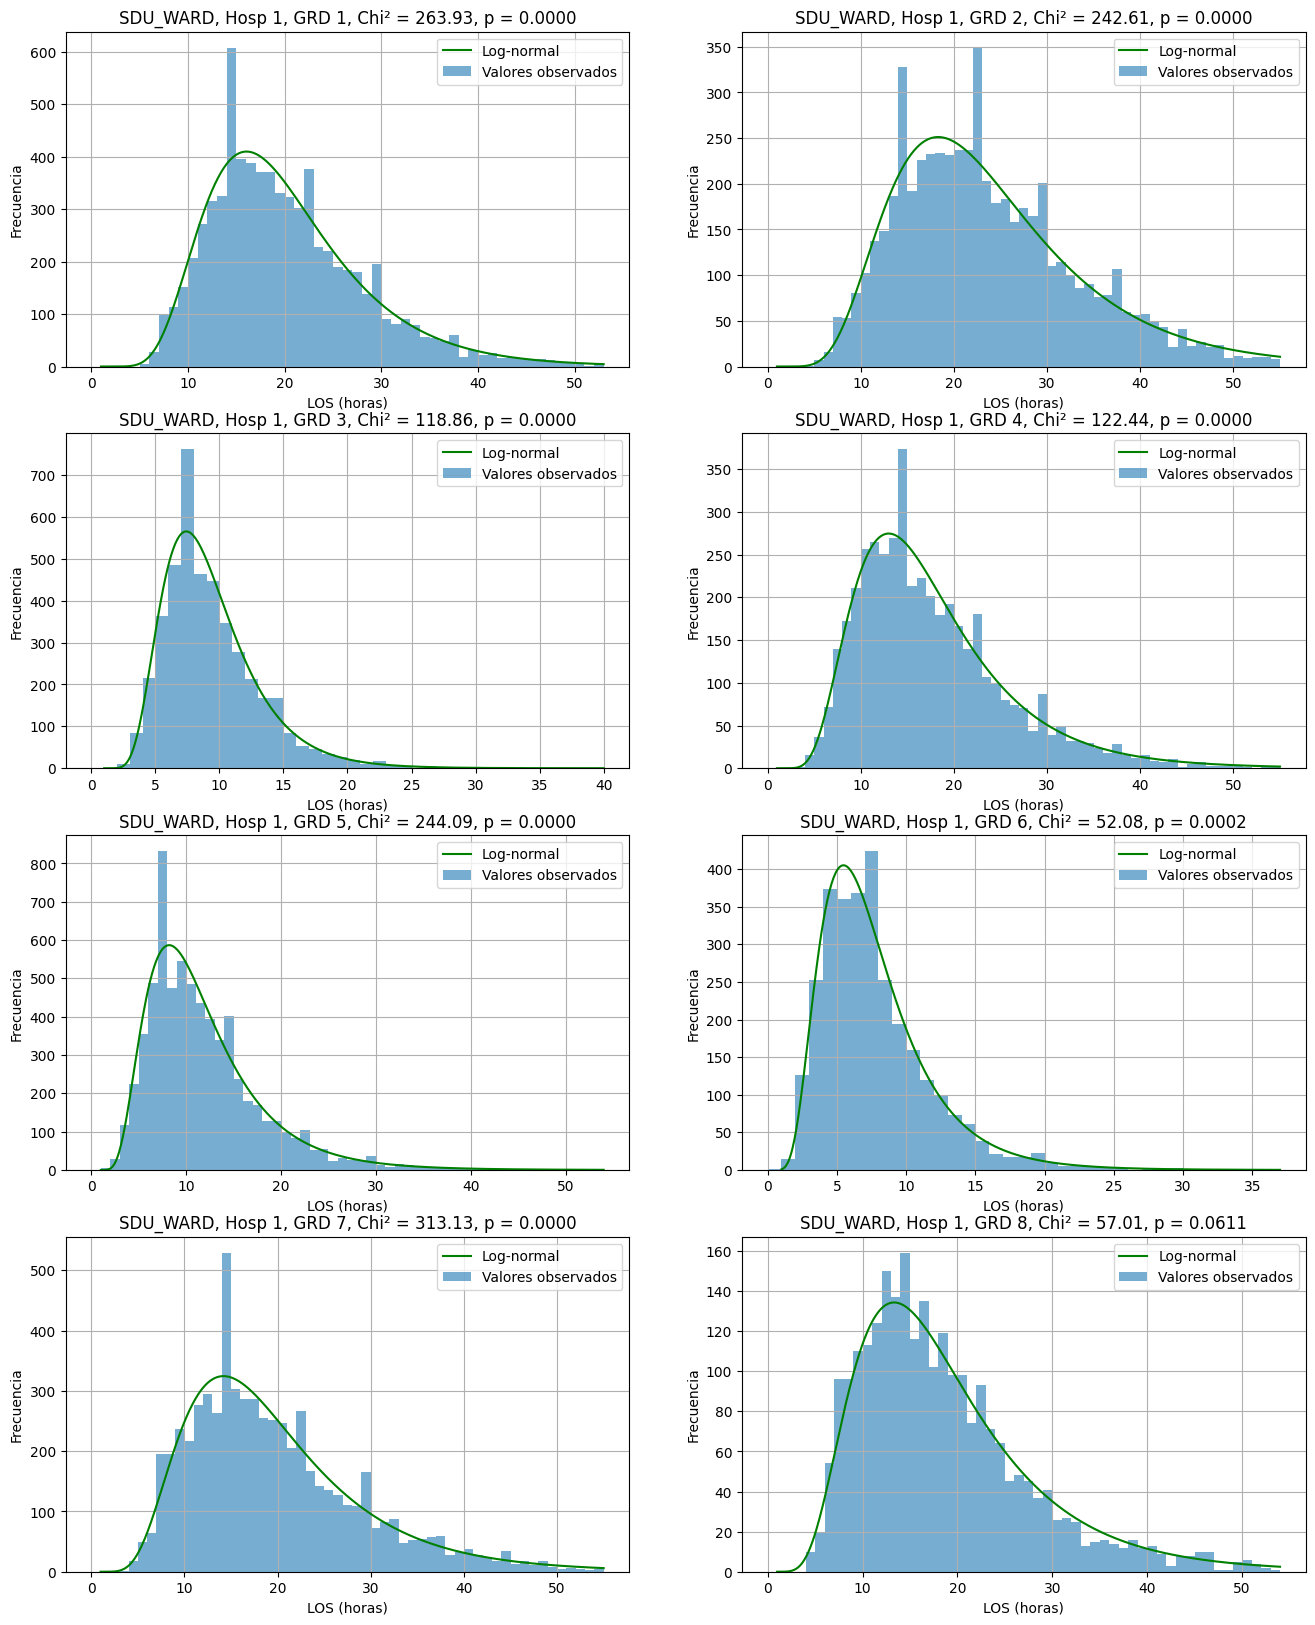

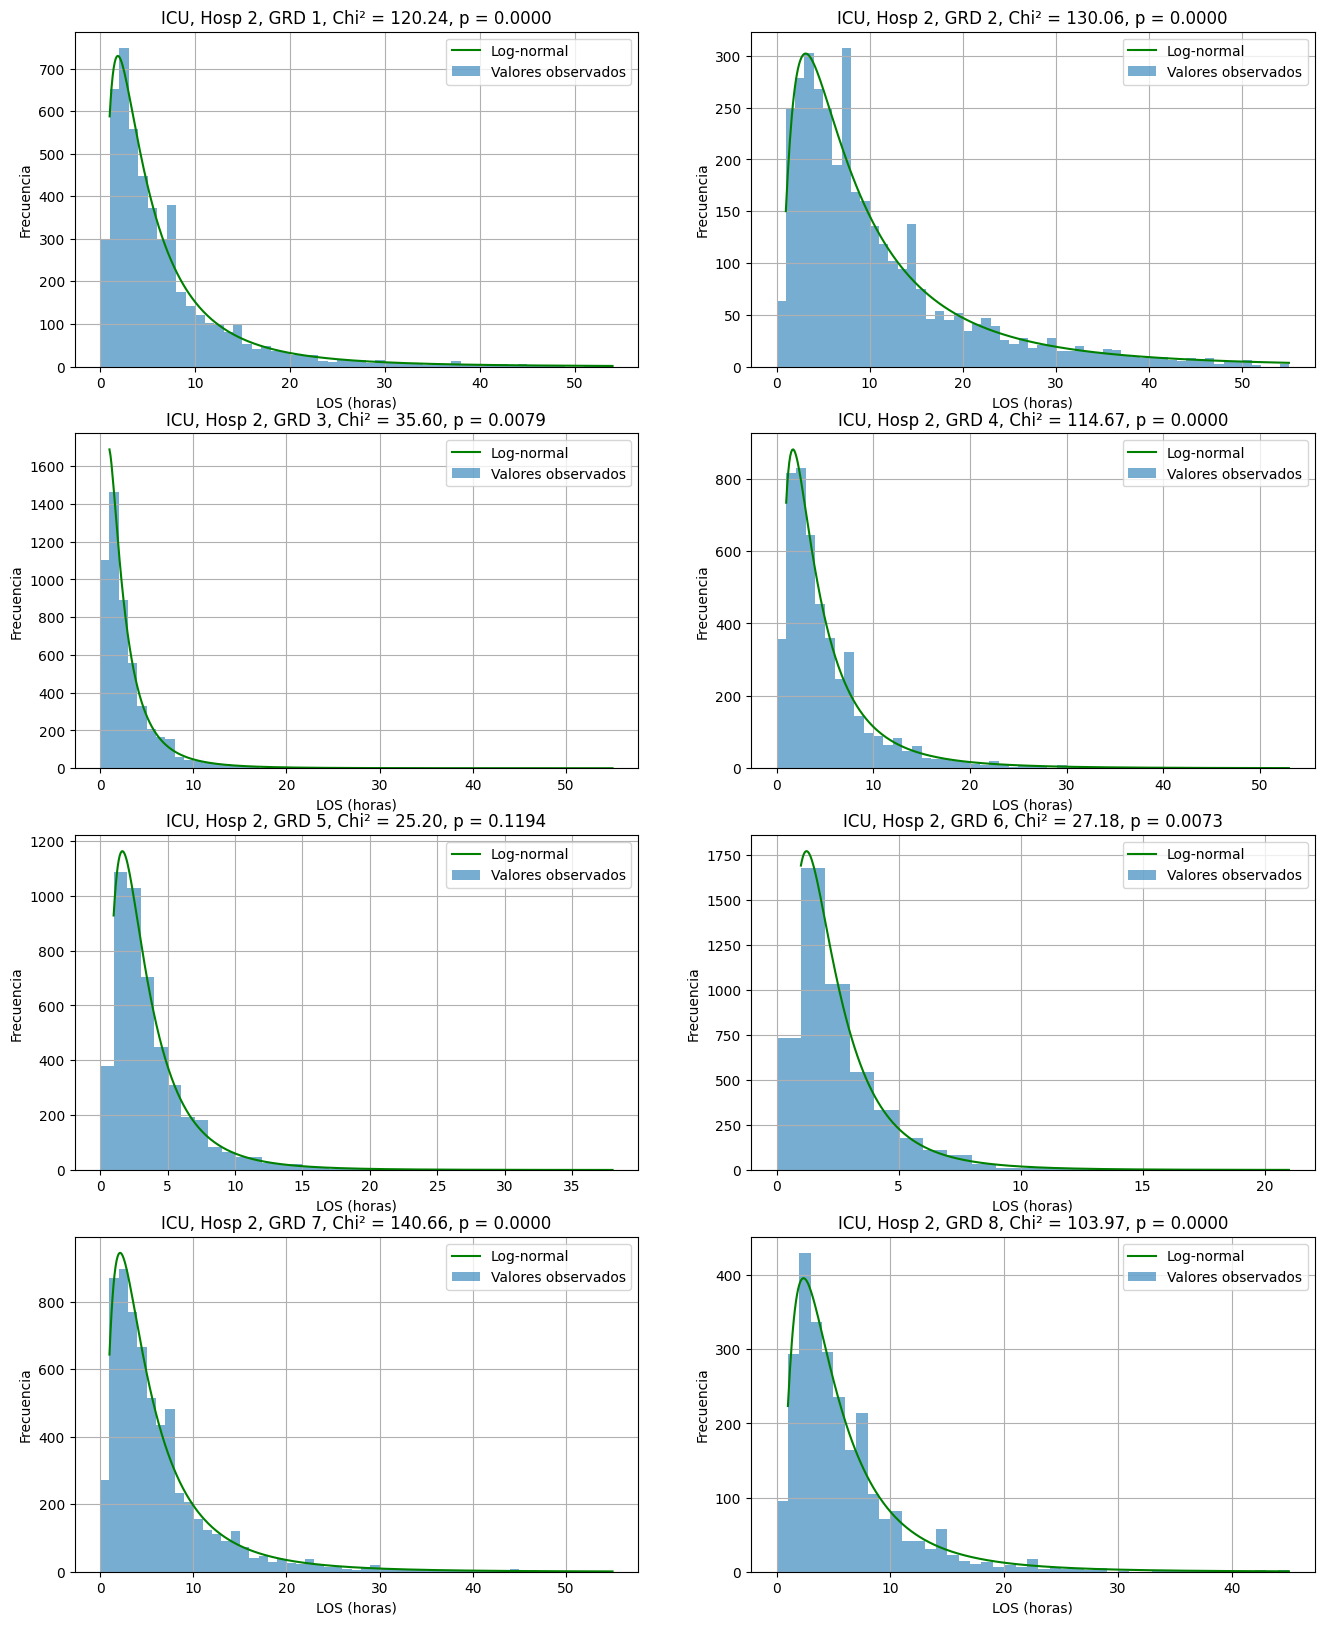

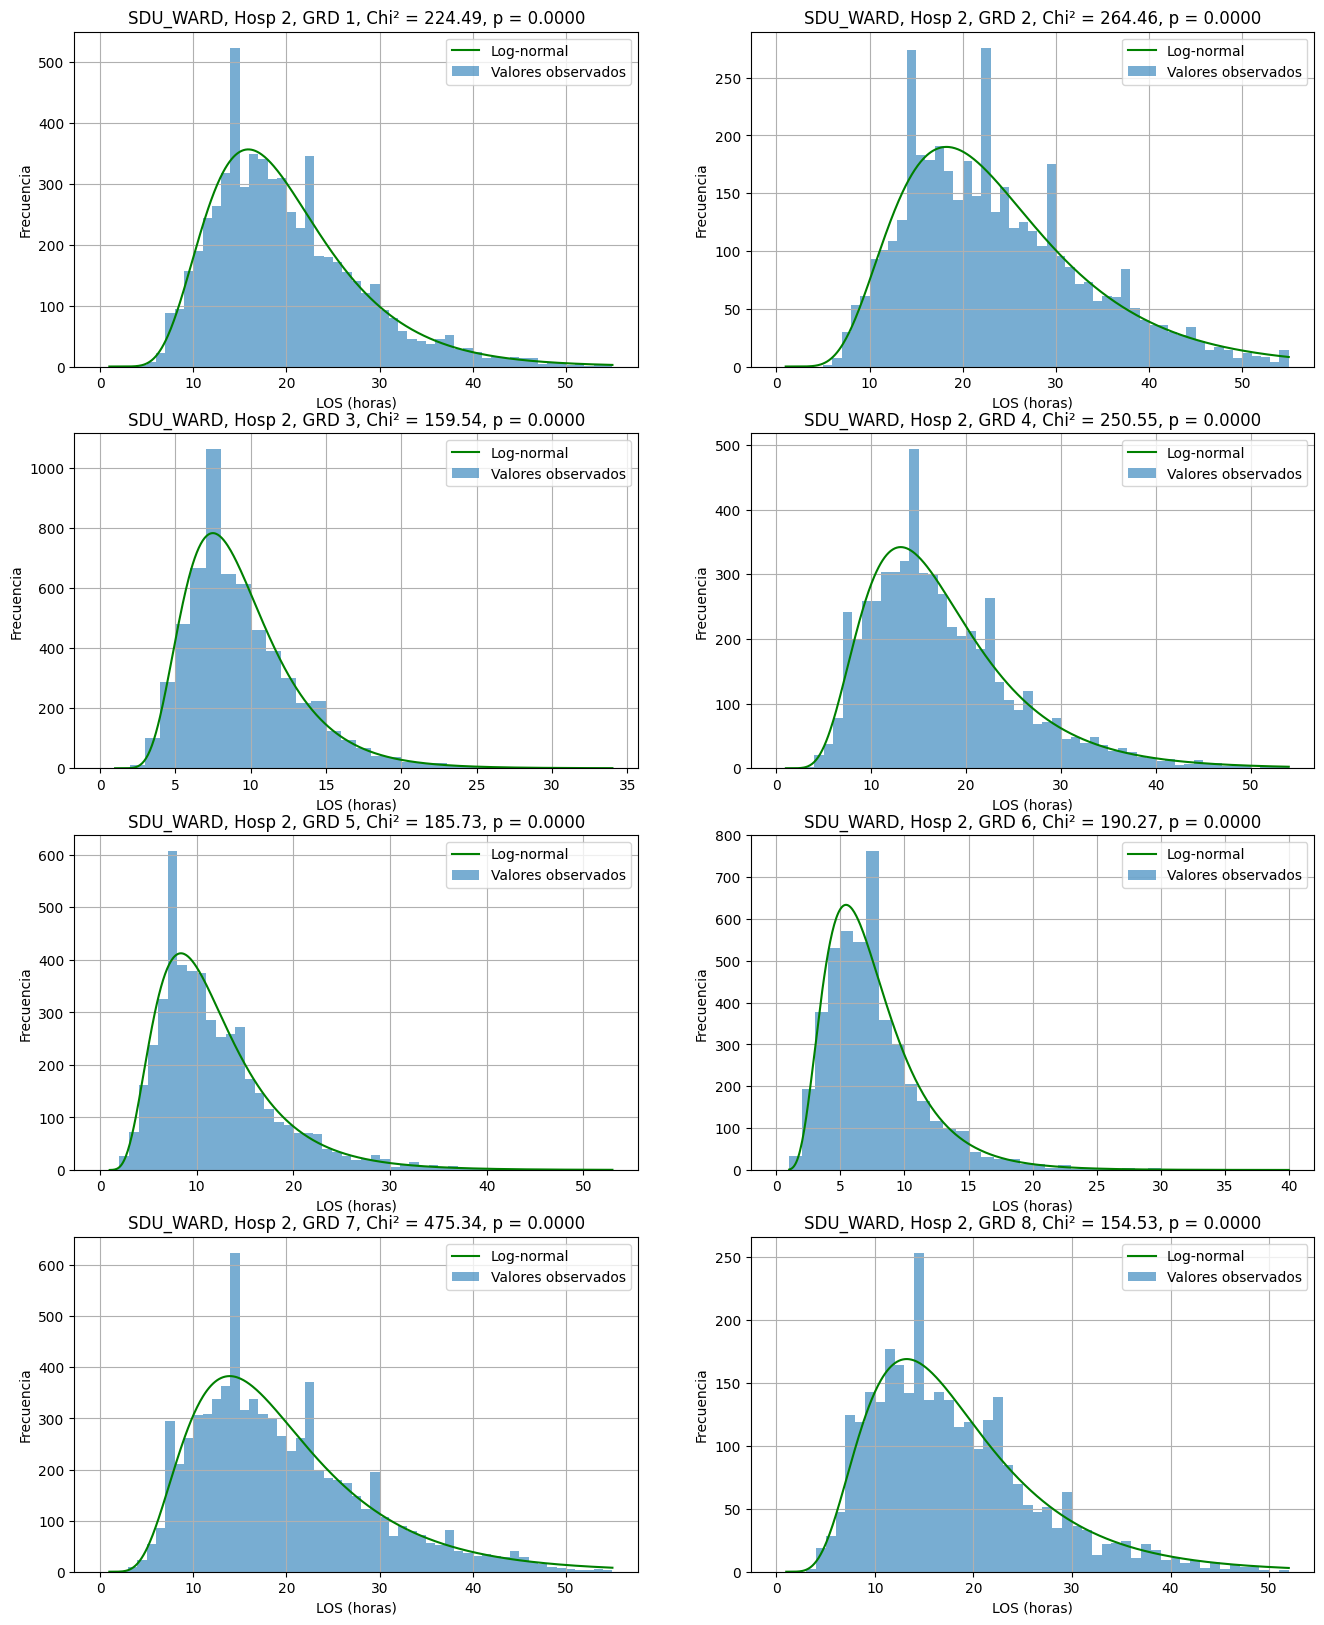

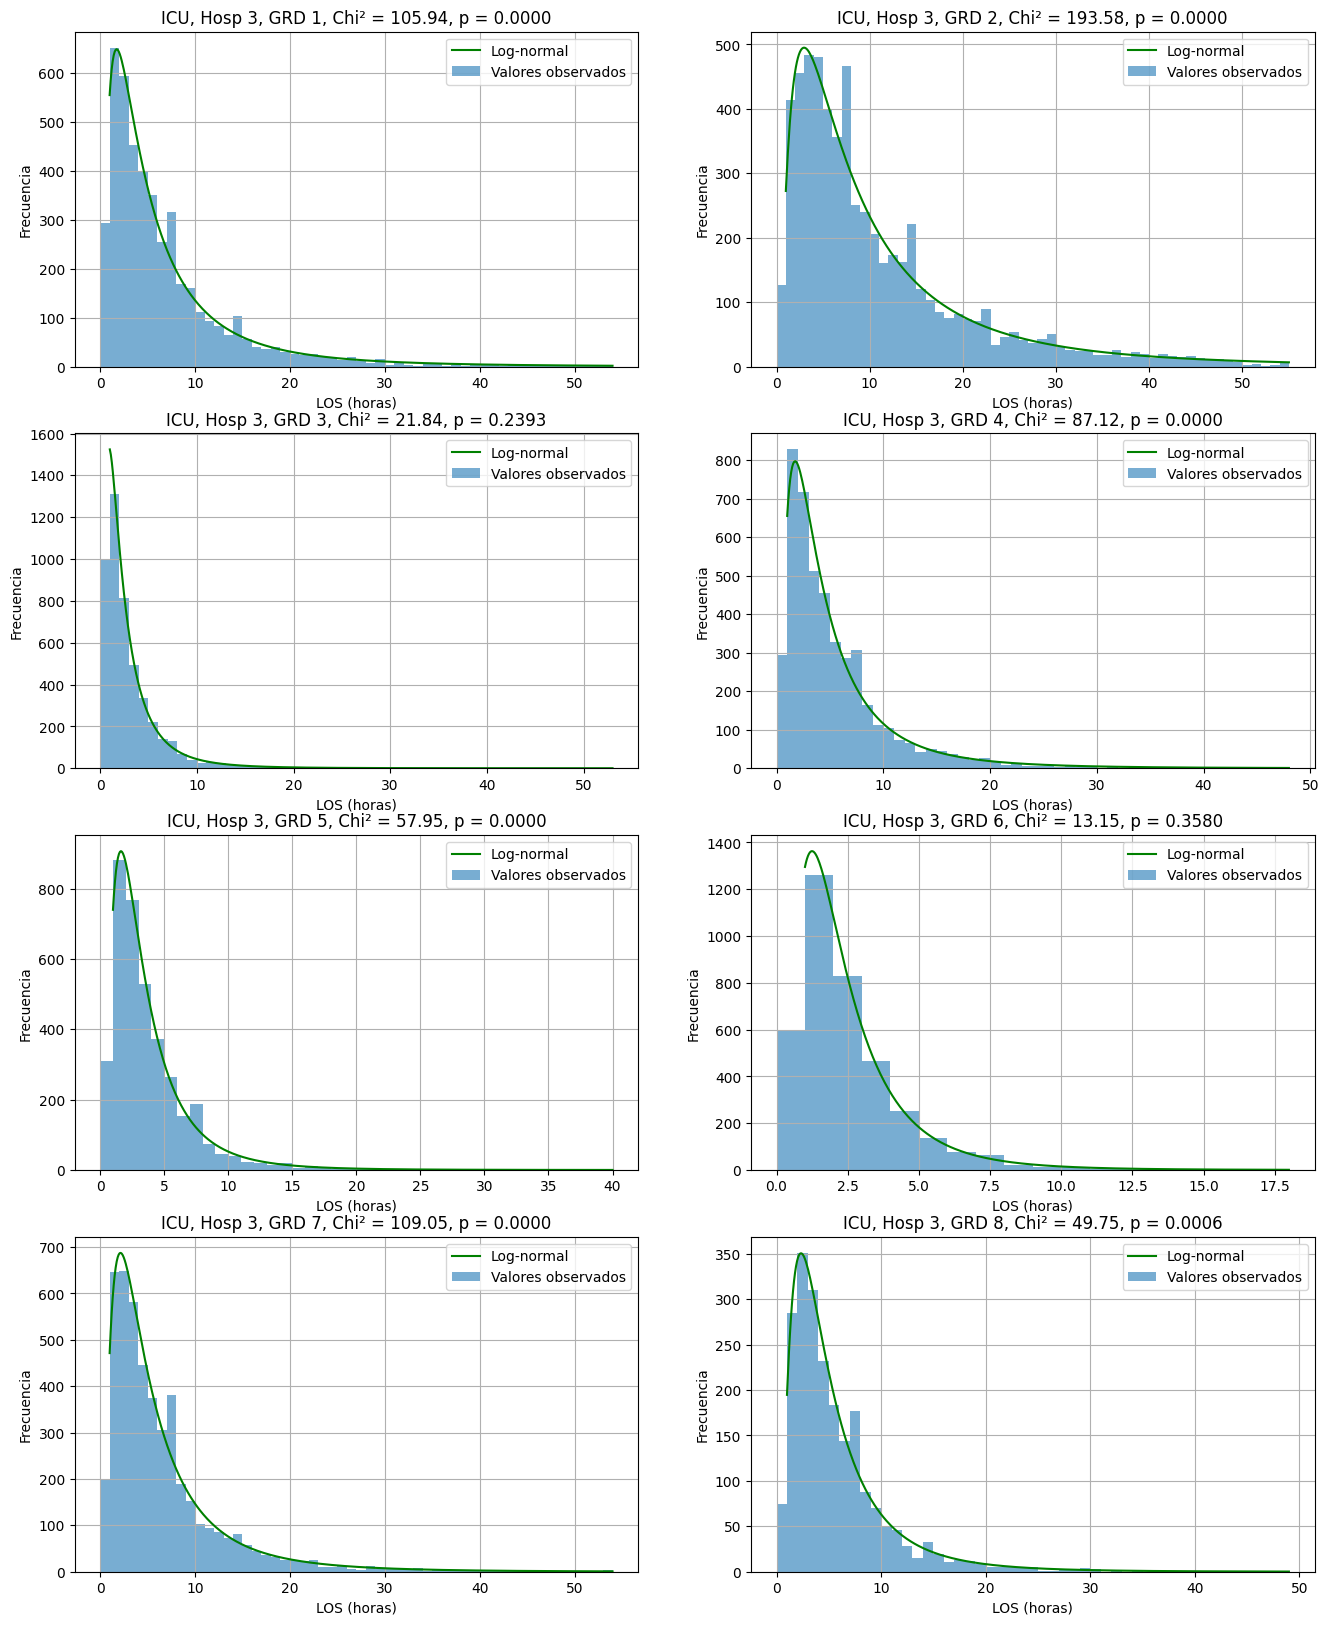

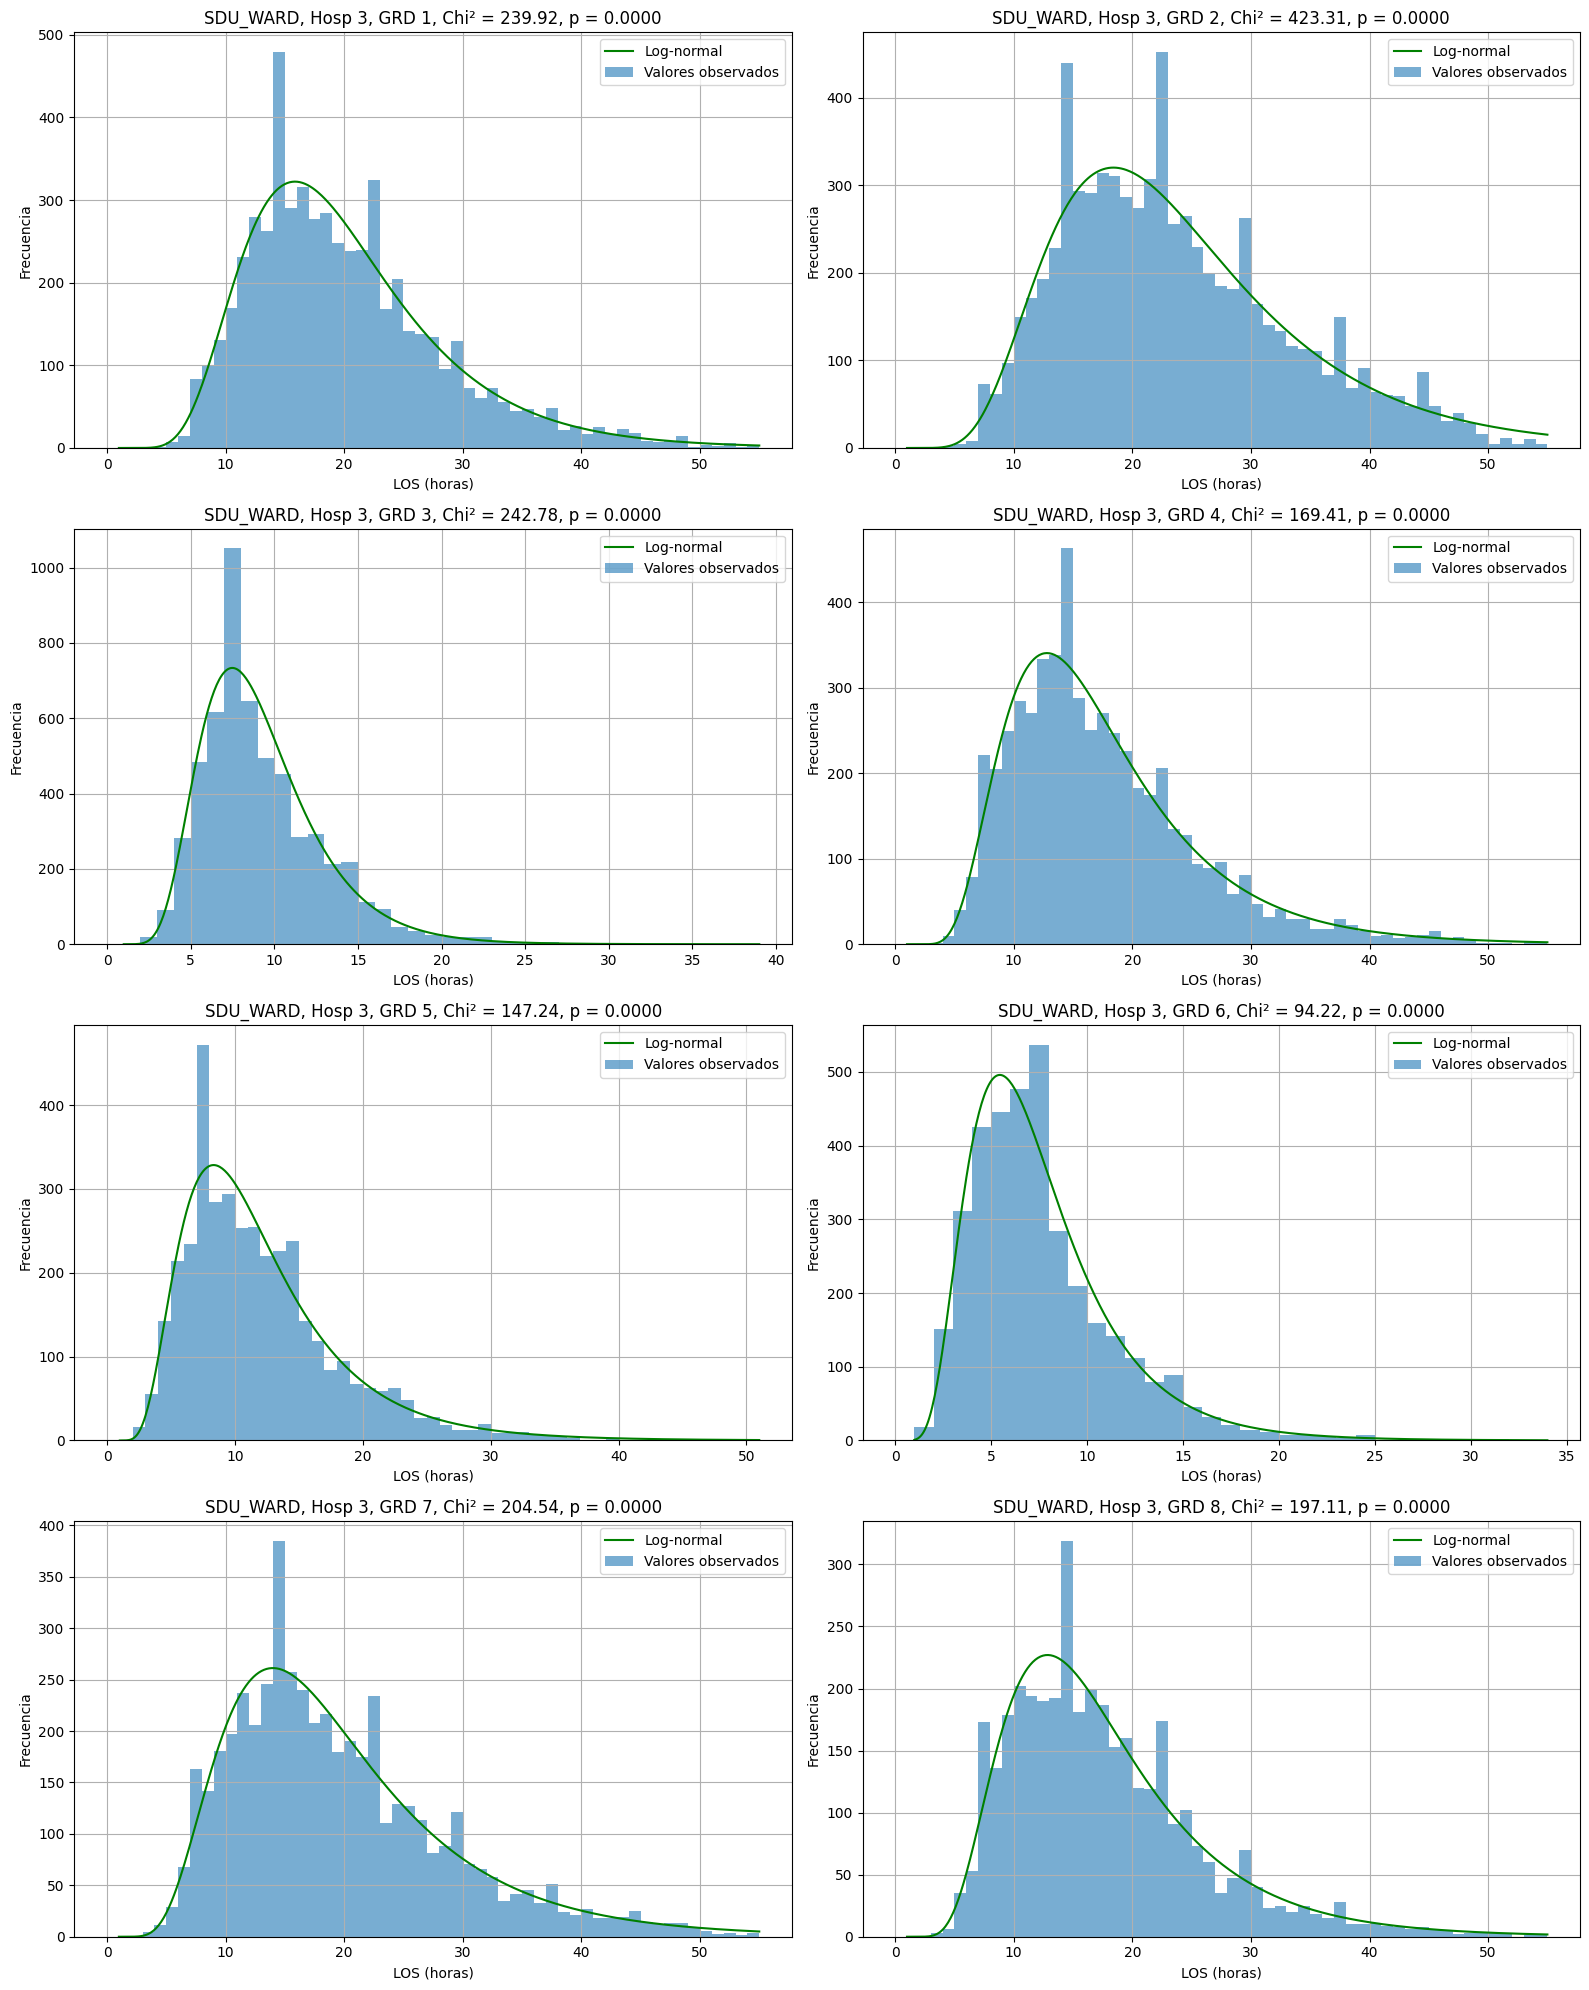

,Hospital,Unidad,GRD,Chi2,p-value
0,1,ICU,1,121.066406,0.0000
1,1,ICU,2,167.880585,0.0000
2,1,ICU,3,16.781905,0.4692
3,1,ICU,4,53.837664,0.0011
4,1,ICU,5,80.402315,0.0000
5,1,ICU,6,11.777824,0.3806
6,1,ICU,7,50.094412,0.0218
7,1,ICU,8,26.578386,0.2743
8,1,SDU_WARD,1,263.932373,0.0000
9,1,SDU_WARD,2,242.614840,0.0000


In [6]:
ajuste_lognormal(tl)

In [7]:
# ---- 1. Filter your dataset
tl_u = tl[tl["UNIDAD"].isin(["ICU", "OR", "SDU_WARD"])]
v1 = tl_u[(tl_u["UNIDAD"] == "ICU") & (tl_u["MS_GRD"] == 1) & (tl_u["HOSPITAL"] == f"Hospital_{1}")]

# ---- 2. Get LOS value counts
vector = v1["LOS"].value_counts().reset_index().sort_values(by="LOS")
vector.columns = ["LOS", "count"]

# ---- 3. Build raw data from LOS values and their frequencies
los = np.array(vector["LOS"])/12
ocurrencias = np.array(vector["count"])
raw_data = np.repeat(los, ocurrencias)

print(los)
print(ocurrencias)
print(los/ocurrencias)

raw_data_uniforme = []
for i in los/ocurrencias:
    for j in range(1, len(ocurrencias) + 1):
        raw_data_uniforme.append(i * j)

print(raw_data_uniforme)


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 50. 51.]
[361 770 796 710 543 440 343 416 226 177 143 140  95 112 112  69  66  55
  50  44  44  28  50  18  22  19  15  16  15  29  13  11   9   7   6   2
   5   5   5   9   7   3   6   6   3   4   3   3   4   3]
[2.77008310e-03 2.59740260e-03 3.76884422e-03 5.63380282e-03
 9.20810313e-03 1.36363636e-02 2.04081633e-02 1.92307692e-02
 3.98230088e-02 5.64971751e-02 7.69230769e-02 8.57142857e-02
 1.36842105e-01 1.25000000e-01 1.33928571e-01 2.31884058e-01
 2.57575758e-01 3.27272727e-01 3.80000000e-01 4.54545455e-01
 4.77272727e-01 7.85714286e-01 4.60000000e-01 1.33333333e+00
 1.13636364e+00 1.36842105e+00 1.80000000e+00 1.75000000e+00
 1.93333333e+00 1.03448276e+00 2.38461538e+00 2.90909091e+00
 3.66666667e+00 4.85714286e+00 5.83333333e+00 1.80000000e+01
 7.40000000e+00 7.60000000e+00 7.80000000e+

# Ajuste a KDE

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import chisquare, kstest, pearsonr, ks_2samp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import parametros as p

In [10]:
def calculate_kde_metrics(data, ocurrencias, kde):
    # Puntos de intersección entre data y kde (en los enteros: 1, 2, 3 ...)
    x_vals = np.linspace(int(min(data)), int(max(data)), int(max(data)) - int(min(data)) + 1)
    log_dens = kde.score_samples(x_vals[:, None])
    kde_pdf = np.exp(log_dens)

    # Almaceno el data y sus ocurrencias en un diccionario
    dict_temporal = {int(data[i]): ocurrencias[i] for i in range(len(data))}
    # Genero ocurrencias nuevamente pero agregando un cero en los intervalos sin ocurrencias
    ocurrencias_con_cero = np.array([dict_temporal.get(i, 0) for i in range(int(min(data)), int(max(data)) + 1)])

    # Calculo las métricas para el kde (que es el unico que voy a usar)
    def get_metrics(y_true, y_pred):
        prediccion = y_pred * (y_true.sum() / y_pred.sum())  # reescala predicciones para el test
        chi2 = chisquare(f_obs=y_true, f_exp=prediccion)
        ks_stat = ks_2samp(y_true, y_pred)
        cc = pearsonr(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae = mean_absolute_error(y_true, y_pred)

        return {
            'Chi2': {"Value": round(chi2.statistic, 3), "p-value": round(chi2.pvalue, 3)},
            'KS': {"Value": round(ks_stat.statistic, 3), "p-value": round(ks_stat.pvalue, 3)},
            'CC': {"Value": round(cc.statistic, 3), "p-value": round(cc.pvalue, 3)},
            'R2': {"Value": round(r2, 3), "p-value": "NA"},
            'RMSE': {"Value": round(rmse, 3), "p-value": "NA"},
            'MAE': {"Value": round(mae, 3), "p-value": "NA"}
        }
    metrics = get_metrics(ocurrencias_con_cero, kde_pdf * ocurrencias.sum())

    return metrics, kde_pdf

In [10]:
def ajuste_kde(dato: list, ocurrencias: list, bandwidth: float = 1, pvalue: float = 0.06, plot: bool = True, titulo_plot: str = "Ajuste KDE"):
    """
    Ajusta un modelo de Kernel Density Estimation (KDE) a los datos proporcionados y calcula métricas de ajuste.
    
    Args:
        dato (list): Lista de datos a ajustar.
        ocurrencias (list): Lista de ocurrencias correspondientes a los datos.
        bandwidth (float): Ancho de banda para el KDE.
        plot (bool): Si True, se graficará el histograma y el KDE ajustado.
    
    Returns:
        dict: Diccionario con las métricas de ajuste.
    """    
    ###################### Datos a analizar ######################
    dato = np.array(dato)/12 
    ocurrencias = np.array(ocurrencias)
    raw_data = np.repeat(dato, ocurrencias)
    ##############################################################
    pvalue_obtenido = 0
    while pvalue_obtenido < pvalue:
        # Estimador del kernerl density discreto #####################
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(raw_data[:, None])
        # Calculo el valor p de la prueba de chi2
        metricas, kde_pdf = calculate_kde_metrics(dato, ocurrencias, kde)
        pvalue_obtenido = metricas["Chi2"]["p-value"]
        # Si el pvalue obtenido es menor al pvalue deseado, disminuyo el ancho de banda
        if pvalue_obtenido < pvalue:
            # Disminuyo el ancho de banda
            bandwidth -= 0.005
            # Si el ancho de banda es menor a 0.01, salgo del while
            if bandwidth < 0.5:
                print("No se encontró un ancho de banda adecuado sobre 0.5")
                break
        ##############################################################

    if plot:
        ###################### Plot ##################################
        # Histograma de los datos, tantos bins como el valor maximo de los datos
        plt.figure(figsize=(10, 3)) # tamaño grafico
        plt.hist(raw_data, bins=int(raw_data[-1] - (raw_data[0] - 1)), density=True, alpha=0.6, color='g', edgecolor='black', label='Histogram')

        # pdf del KDE ajustado a los datos
        x_vals = np.linspace(min(raw_data), max(raw_data), 1000)
        log_dens = kde.score_samples(x_vals[:, None])
        kde_pdf = np.exp(log_dens)
        plt.plot(x_vals, kde_pdf, color='black', label=f'KDE (Bandwidth = {round(bandwidth,2)})')
        # puntos de las intersecciones
        x_vals_puntos = np.linspace(int(min(raw_data)), int(max(raw_data)), int(max(raw_data)) - int(min(raw_data)) + 1)
        log_dens_puntos = kde.score_samples(x_vals_puntos[:, None])
        kde_pdf_puntos = np.exp(log_dens_puntos)
        plt.scatter(x_vals_puntos, kde_pdf_puntos, color='red', label=f'KDE intersecciones')


        # Leyendas y nombres
        plt.xlabel('LOS')
        plt.ylabel('Densidad')
        plt.title(titulo_plot)
        plt.legend()
        plt.grid(True)
        plt.show()
        ##############################################################
    
    return kde, kde_pdf, metricas, bandwidth

In [9]:
tl_u = tl[tl["UNIDAD"].isin(["ICU", "SDU_WARD"])]
v1 = tl_u[(tl_u["UNIDAD"] == "ICU") & (tl_u["MS_GRD"] == 6) & (tl_u["HOSPITAL"] == f"Hospital_{1}")]
vector = v1["LOS"].value_counts().reset_index().sort_values(by="LOS")
vector.columns = ["LOS", "count"]
vector["LOS"] = vector["LOS"] // int(12)
display(vector)
# titulo_plot = "Ajuste KDE de LOS: Hospital 1, Unidad SDU_WARD, GRD 1"
# kde, kde_pdf, metricas, bandwidth = ajuste_kde(vector["LOS"], vector["count"], bandwidth=1, pvalue=0.06, plot=True, titulo_plot = titulo_plot)

# chi2 = metricas["Chi2"]["Value"]
# pvalue = metricas["Chi2"]["p-value"]
# display(pd.DataFrame(metricas))

,LOS,count
2,1,486
0,2,1086
1,3,685
3,4,392
4,5,190
5,6,105
6,7,56
7,8,52
8,9,18
9,10,18


In [12]:
# Uso de funciones para ajustes de todos los LOS de ICU, SDU_WARD por Hospital y GRD

todo = {}
resultados = []
tl_u = tl[tl["UNIDAD"].isin(["ICU", "SDU_WARD"])]
for i in range(1, 4): # ranfo hospitales
    todo[i] = {}
    for unidad in ["ICU", "SDU_WARD"]:
        todo[i][p.dict_unidades[unidad.replace("_","/")]] = {} # Base de datos tiene SDU_WARD, pero en el resto del código se usa SDU/WARD
        for grd in range(1, 9):
            v1 = tl_u[(tl_u["UNIDAD"] == unidad) & (tl_u["MS_GRD"] == grd) & (tl_u["HOSPITAL"] == f"Hospital_{i}")]
            vector = v1["LOS"].value_counts().reset_index().sort_values(by="LOS")
            vector.columns = ["LOS", "count"]
            # Ajuste a kde y calculo de metricas
            kde, kde_pdf, metricas, bandwidth = ajuste_kde(vector["LOS"], vector["count"], bandwidth=1, pvalue=0.055, plot=False, titulo_plot=f'Hospital {i}, Unidad {unidad}, GRD {grd}')


            # Almacenaje de resultados
            chi2 = metricas["Chi2"]["Value"]
            pvalue = metricas["Chi2"]["p-value"]
            resultados.append({
                "Hospital": i,
                "Unidad": unidad,
                "GRD": grd,
                "Chi2": chi2,
                "p-value": pvalue,
                "Bandwidth": bandwidth
            })
            todo[i][p.dict_unidades[unidad.replace("_","/")]][grd] = {
                "kde": kde,
                "kde_pdf": kde_pdf.tolist(),  # Convert numpy array to list for JSON compatibility
                "metricas": metricas,
                "bandwidth": bandwidth
            }
            print(f"Hospital {i}, Unidad {unidad}, GRD {grd}, Chi2: {chi2}, p-value: {pvalue}, Bandwidth: {bandwidth}")


Hospital 1, Unidad ICU, GRD 1, Chi2: 66.382, p-value: 0.06, Bandwidth: 0.8149999999999998
Hospital 1, Unidad ICU, GRD 2, Chi2: 71.229, p-value: 0.058, Bandwidth: 0.8049999999999998
Hospital 1, Unidad ICU, GRD 3, Chi2: 40.435, p-value: 0.06, Bandwidth: 0.6399999999999997
Hospital 1, Unidad ICU, GRD 4, Chi2: 65.348, p-value: 0.059, Bandwidth: 0.8049999999999998
Hospital 1, Unidad ICU, GRD 5, Chi2: 50.805, p-value: 0.065, Bandwidth: 0.5499999999999996
Hospital 1, Unidad ICU, GRD 6, Chi2: 26.101, p-value: 0.073, Bandwidth: 0.5599999999999996
Hospital 1, Unidad ICU, GRD 7, Chi2: 71.622, p-value: 0.055, Bandwidth: 0.8449999999999999
Hospital 1, Unidad ICU, GRD 8, Chi2: 52.705, p-value: 0.057, Bandwidth: 0.955
Hospital 1, Unidad SDU_WARD, GRD 1, Chi2: 64.593, p-value: 0.067, Bandwidth: 0.6399999999999997
Hospital 1, Unidad SDU_WARD, GRD 2, Chi2: 66.568, p-value: 0.058, Bandwidth: 0.7149999999999997
Hospital 1, Unidad SDU_WARD, GRD 3, Chi2: 52.407, p-value: 0.06, Bandwidth: 0.6799999999999997
